<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Introduction to FlowDirAccPf (priorityFlood filler, director and accumulator)

Landlab directs flow and accumulates it using FlowDirectors to determine how flow moves between adjacent nodes and a FlowAccumulator that uses the direction and proportion of flow moving between each node and (optionally) water runoff to calculate drainage area and discharge. 

Here we showcase an alternative flow router and accumualtor that wraps an external python package (richdem).  The **FlowDirAccPf** component combines filling, flow direction and accumualtion of water over structured grids in one component and significantly improves performaces of flow accumualtion and direction operations over large grids, especially when filling operations are required to route water over landscapes.

This notebook follows the structure of the FlowAccumulator and flow director notebook.  
First, we import the necessary python modules and make a small plotting routine. 

In [1]:
%matplotlib inline

In [2]:
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl

# import numpy
import numpy as np

# import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import FlowDirAccPf

# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot


# create a plotting routine to make a 3d plot of our surface.
def surf_plot(mg,
              surface='topographic__elevation',
              title='Surface plot of topography'):

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z - Z.min()) / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Topographic grids

For this tutorial we will consider one topographic surface. Here it is plotted in three dimensions. 

<ipython-input-2-d376059d2562>:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


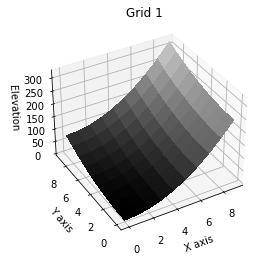

In [3]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
surf_plot(mg, title='Grid 1')

## Initalizing and running the FlowAccumulator

To instantiate the **FlowDirAccPf**, you must pass it the minimum of a model grid that has a field called ```'topographic__elevation'```. The default behavior to deal with depressions internally. Taking care of depressions is done using the 'RichDEM' filling or breaching algorithm. The `depressionHandler` variable can be set to 'fill or 'breach' to use respectively a filling or breaching algorithm to handle depressions. If DEMs do not need to be filled, set `updateFlowDepressions` to False. 


Similar to other landlab flow accumulators, **FlowDirAccPf** can take a constant or spatially variable input called ```runoff_rate```, which it uses to calculate discharge. Alternatively, if there is an `at_node` field called ```water__unit_flux_in``` and no value is specified as the ```runoff_rate```, **FlowDirAccPf** will use the values stored in ```water__unit_flux_in```.

In addition to directing flow and accumulating it in one step, **FlowAccumulator** can also deal with depression finding internally. This can be done by passing a **DepressionFinder** to the keyword argument ```depression_finder```. The default behavior is to not deal with depressions internally. 

The `flow_metric` variable controlls the way in which water is routed over teh landscape: Various options possible: 
            * D8 (O’Callaghan and Mark, 1984) {default}
            * Rho8 (Fairfield and Leymarie, 1991)
            * Quinn (1991)
            * Freeman (1991)
            * Holmgren (1994)
            * D∞ (Tarboton, 1997)
For details and comparison, see https://richdem.readthedocs.io/en/latest/flow_metrics.html
Some of these methods require an exponent, which can be provided throught the `exponent` variable. 
When routing flow, one challenge is to define water directions in flat regions. This is way an articifical small graident is introduced in flat areas. If you want to have such routing option in flat areas, set the `epsilon` variable to True {default is True}. This ensures that there is always a local gradient.


For some applications both single and multiple flow direction and accumulation is required. 
By calculating them in the same component, we can optimize procedures invovled with filling and breaching of DEMs. Set the `seperate_Hill_Flow` variable to True if you want a second flow accumualtor calcuatled on the same filled DEM data. 

In [4]:
fa = FlowDirAccPf(mg)

# # this is the same as writing:
fa = FlowDirAccPf(mg,
                     surface='topographic__elevation',
                     flow_metric='D8',
                     updateFlowDepressions = True,
                     runoff_rate=None,
                     depressionHandler='fill')

The **FlowAccumulator** has one public methods: ```run_one_step()```.

In [5]:
fa.run_one_step()

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


We can illustrate the receiver node **FlowDirectionSteepest** has assigned to each donor node using a plotting function in Landlab called ```drainage_plot```. We will see many of these plots in this tutorial so let's take a moment to walk through the plot and what it contains. 

   - The background image (white to black) shows the values of topographic elevation of the underlying surface or any other at_node field we choose to plot.

   - The colors of the dots inside of each pixel show the locations of the nodes and the type of node. 

   - The arrows show the direction of flow, and the color shows the proportion of flow that travels along that link. 

   - An X on top of a node indicates that node is a local sink and flows to itself. 

Note that in Landlab *Boundary Nodes*, or nodes that are on the edge of a grid, do not have area and do not contribute flow to nodes. These nodes can either be *Fixed Gradient Nodes*, *Fixed Value Nodes*, or *Closed Nodes*. With the exception of *Closed Nodes* the boundary nodes can receive flow. 

An important step in all flow direction and accumulation is setting the proper boundary condition. Refer to the boundary condition tutorials for more information.  

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


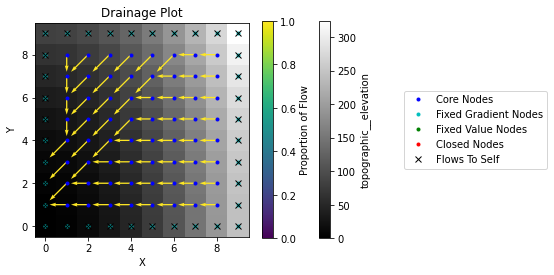

In [6]:
plt.figure()
drainage_plot(mg)

In this drainage plot, we can see that all of the flow is routed down the steepest link. A plot of the drainage area would illustrate how the flow would move. Next let's make a similar plot except that instead of plotting the topographic elevation as the background, we will plot the drainage area. 

/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


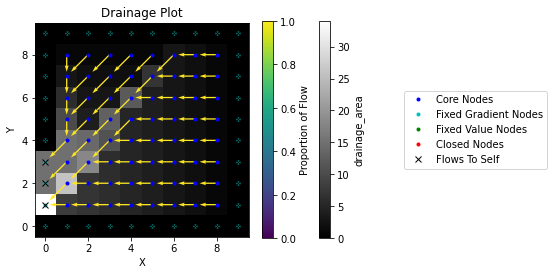

In [7]:
plt.figure()
drainage_plot(mg, 'drainage_area')

If we print out the drainage area, we can see that its maximum reaches 64, which is the total area of the interior of the grid.

In [8]:
print(mg.at_node['drainage_area'].reshape(mg.shape))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 34.   8.   7.   6.   5.   4.   3.   2.   1.   0.]
 [ 15.  26.   7.   6.   5.   4.   3.   2.   1.   0.]
 [ 15.  15.  18.   6.   5.   4.   3.   2.   1.   0.]
 [  0.  15.  14.  11.   5.   4.   3.   2.   1.   0.]
 [  0.  10.   4.  13.   5.   4.   3.   2.   1.   0.]
 [  0.   6.   3.   3.  12.   4.   3.   2.   1.   0.]
 [  0.   3.   2.   2.   2.   7.   3.   2.   1.   0.]
 [  0.   1.   1.   1.   1.   1.   3.   2.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


This is the same number as the number of core nodes. This makes sense becaue these are the only nodes in Landlab that have area, and in our model grid they each have an area of one. 

In [9]:
print(mg.number_of_core_nodes)

64


We can rain on the surface, store that rain in the field ```water__unit_flux_in```, and then re-run the **FlowAccumulator**. As an example, we will 'rain' a uniformly distributed random number between 0 and 1 on every node. 

Since we already ran the **FlowAccumulator**, under the hood our grid already has a field called ```water__unit_flux_in``` and we need to set the ```clobber``` keyword to ```True```.

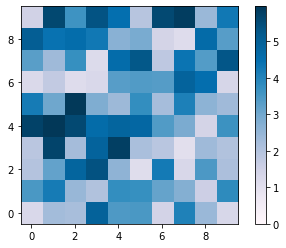

In [10]:
rain = 1. + 5. * np.random.rand(mg.number_of_nodes)

plt.imshow(rain.reshape(mg.shape), origin='lower', cmap='PuBu', vmin=0)
plt.colorbar()
plt.show()

_ = mg.add_field('water__unit_flux_in', rain, at='node', clobber=True)

Next, we re-run the **FlowAccumulator** and plot the discharge. 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


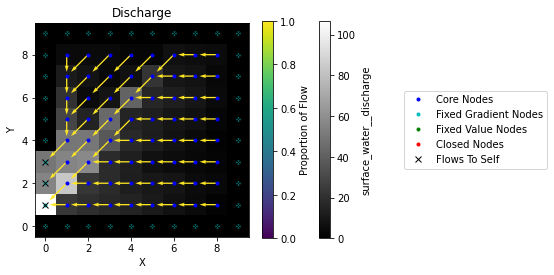

In [11]:
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')

The basic pattern of drainage is the same but the values for the surface water discharge are different than for drainage area. 

### Various flow routing algorithms 
* D4

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


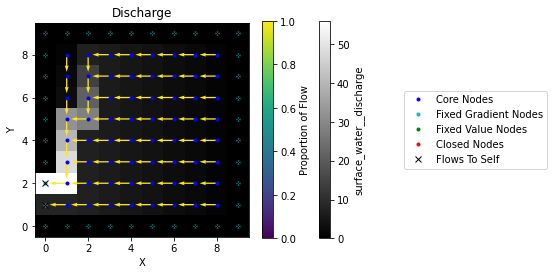

In [14]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
fa = FlowDirAccPf(mg,
                     surface='topographic__elevation',
                     flow_metric='D4')
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')

* Rho8

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


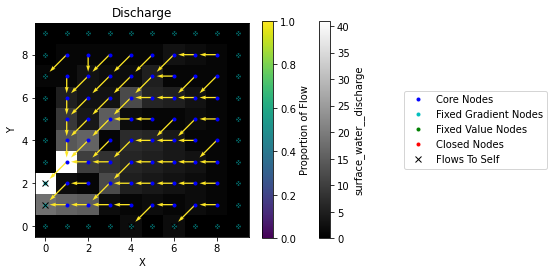

In [16]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
fa = FlowDirAccPf(mg,
                     surface='topographic__elevation',
                     flow_metric='Rho8')
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')

* Rho4

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


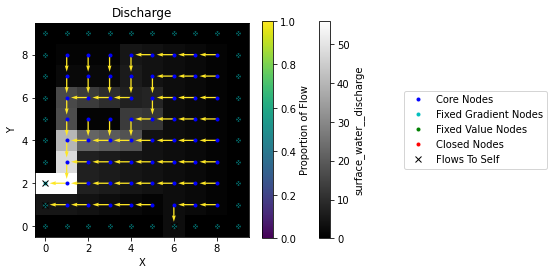

In [18]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
fa = FlowDirAccPf(mg,
                     surface='topographic__elevation',
                     flow_metric='Rho4')
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')

* Quinn

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


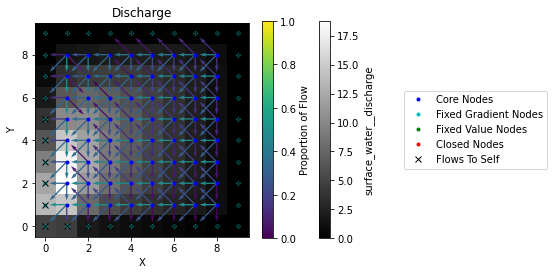

In [20]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
fa = FlowDirAccPf(mg,
                     surface='topographic__elevation',
                     flow_metric='Quinn')
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')

* Freeman

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


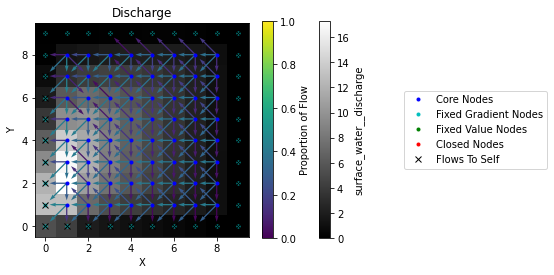

In [24]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
fa = FlowDirAccPf(mg,
                     surface='topographic__elevation',
                     flow_metric='Freeman')
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')

* Holmgren

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


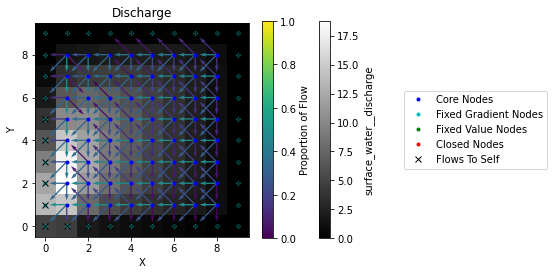

In [26]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
fa = FlowDirAccPf(mg,
                     surface='topographic__elevation',
                     flow_metric='Holmgren')
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')

* Dinf

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:302: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color=color_for_closed)
/Users/beca4397/Google_Drive/landlab/landlab/plot/imshow.py:342: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


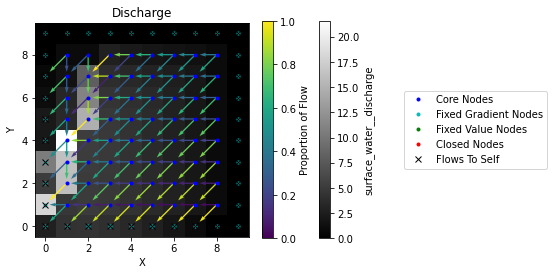

In [27]:
mg = RasterModelGrid((10, 10))
_ = mg.add_field('topographic__elevation',
                 3. * mg.x_of_node**2 + mg.y_of_node**2,
                 at='node')
fa = FlowDirAccPf(mg,
                     surface='topographic__elevation',
                     flow_metric='Dinf')
fa.run_one_step()
plt.figure()
drainage_plot(mg, 'surface_water__discharge', title='Discharge')